<a href="https://colab.research.google.com/github/falseywinchnet/EpistemicGPT/blob/main/Reasoning_Able_Pretrained_Engine_(RAPE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class LELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = math.pi / math.sqrt(3.0)

    def forward(self, x):
        return x * torch.sigmoid(self.scale * x)

class RoPE(nn.Module):
    def __init__(self, dim, max_len=4096):
        super().__init__()
        assert dim % 2 == 0
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, *, T, D)
        T = x.shape[-2]
        cos = self.cos[:T, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:T, :].unsqueeze(0).unsqueeze(0)

        # Adjust shapes for broadcasting if x has extra dims (like n_branch)
        while cos.ndim < x.ndim:
            cos = cos.unsqueeze(0)
            sin = sin.unsqueeze(0)

        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        y1 = x1 * cos - x2 * sin
        y2 = x1 * sin + x2 * cos
        return torch.stack((y1, y2), dim=-1).flatten(-2)

class InertialManifold(nn.Module):
    def __init__(
        self,
        config,
        palette_size: int = 16,     # H, W of the manifold
        kernel_size: int = 15,      # Bandwidth of the inertial filter
        expansion_factor: int = 2,  # Expansion for the output mixing
    ):
        super().__init__()
        self.d = config.n_embd
        self.h_pal = palette_size
        self.w_pal = palette_size
        self.history_dropout = getattr(config, 'history_dropout', 0.1) # Probability to drop a time-step

        # 1. The Territory (Palette)
        self.palette = nn.Parameter(
            torch.randn(1, config.n_embd, palette_size, palette_size) * (config.n_embd ** -0.5)
        )

        # 2. The Inertial Filter (Compass)
        self.norm = nn.LayerNorm(config.n_embd)
        self.inertial_conv = nn.Conv1d(
            in_channels=config.n_embd,
            out_channels=config.n_embd,
            kernel_size=kernel_size,
            padding=kernel_size - 1, # Causal padding
            groups=config.n_embd,    # Depthwise
            bias=False
        )

        # 3. The Navigator (now with Dropout)
        # Projects smoothed state -> (u, v) coordinates.
        self.navigator = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd // 2,bias=config.bias),
            LELU(),
            nn.Dropout(config.dropout), # Added Dropout
            nn.Linear(config.n_embd // 2, 2,bias=config.bias),
            nn.Tanh()
        )

        # 4. Integration (Output Projection) (now with Dropout)
        self.output_proj = nn.Sequential(
            nn.Linear(config.n_embd, config.n_embd * expansion_factor,bias=config.bias),
            LELU(),
            nn.Dropout(config.dropout), # Added Dropout
            nn.Linear(config.n_embd * expansion_factor, config.n_embd,bias=config.bias),
            nn.Dropout(config.dropout)  # Added Final Dropout
        )

        nn.init.dirac_(self.inertial_conv.weight)

    def forward(self, x):
        B, T, D = x.shape

        # --- A. Inertial Smoothing ---
        # Normalize
        # Epistemic Dropout: Drop Time-Steps (History Perforation)
        # We drop the input signal at random positions.
        # The Conv1d must use the kernel's momentum to bridge the gap.

        x_ = x #pass through

        # Transpose for Conv1d: (B, T, D) -> (B, D, T)
        x_in = x_.transpose(1, 2)

        # Apply causal filter
        x_smooth = self.inertial_conv(x_in)[:, :, :T]
        x_smooth = x_smooth.transpose(1, 2)   # (B, T, D)

        # --- B. Navigation ---
        coords = self.navigator(x_smooth)
        grid = coords.view(B, 1, T, 2)

        # --- C. Territory Lookup ---
        batch_palette = self.palette.expand(B, -1, -1, -1)

        retrieved = F.grid_sample(
            batch_palette,
            grid,
            mode='bilinear',
            padding_mode='border',
            align_corners=True
        )

        retrieved = retrieved.squeeze(2).transpose(1, 2)

        # --- D. Integration ---
        y = self.output_proj(retrieved)

        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_branch = 4
        self.block_size = config.block_size
        self.history_dropout = getattr(config, 'history_dropout', 0.1) # Default 10%

        # Projections
        self.q_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.k_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Sinks
        self.v_sink_residual = nn.Parameter(torch.zeros(1, 1, 1, config.n_embd))
        self.v_sink_basis = nn.Parameter(torch.zeros(1, self.n_branch, 1, config.n_embd))

        # Register mask as non-persistent to fix the device mismatch bug
        self.register_buffer("mask", config.mask, persistent=False)

        self.rope = config.rope
        self.attn_drop = nn.Dropout(config.dropout)

    def forward(self, a, x):
        B, T, C = x.shape
        NB = self.n_branch
        device = x.device

        # 1. Projections
        q = self.q_proj(a).view(B, T, NB, C).transpose(1, 2)
        q = norm(q)
        v = self.v_proj(a).view(B, T, NB, C).transpose(1, 2)
        k = self.k_proj(x).view(B, T, 1, C).transpose(1, 2)

        # 2. RoPE
        q, k = self.rope(q), self.rope(k)

        # 3. Raw Scores
        att = (q @ k.transpose(-2, -1)) / math.sqrt(C)

        # 4. Masking Logic
        # A. Standard Causal Mask
        causal_mask = self.mask[:, :, :T, :T]
        att = att.masked_fill(causal_mask == 0, float("-inf"))

        # B. Stochastic History Dropout (Epistemic Perforation)
        # We drop random connections in the history (k < t)
        # but we MUST preserve the diagonal (k == t) so the Query isn't blinded.


        # 5. Branch Routing (Lazy Softmax Patch)
        # We replace the totalitarian F.softmax with a permissive normalization.
        # This allows the sum of branch probabilities to be < 1.0 (Lazy),
        # but prevents it from exceeding 1.0.

        # A. Activation (Softplus > Exp for stability and linearity)
        branch_scores = F.softplus(att)

        # B. Aggregation
        branch_sums = branch_scores.sum(dim=1, keepdim=True)

        # C. Lazy Normalization (Down to 1.0, never up)
        branch_scale = torch.clamp(1.0 / (branch_sums + 1e-6), max=1.0)
        soft_probs = branch_scores * branch_scale

        soft_probs = torch.nan_to_num(soft_probs, nan=0.0)
        #softmax adjustment to bring us to 1.0 without softmax because torch bitches
        soft_probs = soft_probs + (1.0 - soft_probs.sum(dim=1, keepdim=True)).clamp(min=0.0) / soft_probs.size(1)

        # D. Hard Routing (Straight-Through Estimator)
        with torch.no_grad():
            max_val = soft_probs.max(dim=1, keepdim=True)[0]
            # If multiple branches are equal max, this picks all of them (multi-hot),
            # which is fine/good for equivalent hypotheses.
            hard_mask = (soft_probs == max_val).float()

        # The gradients flow through soft_probs, which now reflects the "Lazy" confidence.
        route_mask = (hard_mask - soft_probs).detach() + soft_probs

        # 6. Temporal Normalization
        scores_max, _ = att.max(dim=1)
        s = F.softplus(scores_max)
        S = s.sum(dim=-1, keepdim=True)
        scale = torch.clamp(1.0 / (S + 1e-6), max=1.0)

        w = s * scale
        w = self.attn_drop(w) # Standard dropout on weights still applies

        residual = 1.0 - w.sum(dim=-1, keepdim=True)

        # 7. Composition
        combined_weights = w.unsqueeze(1) * route_mask
        y_context = (combined_weights @ v)

        branch_activity = route_mask.max(dim=-1, keepdim=True)[0]
        y_basis = branch_activity * self.v_sink_basis

        y_branches = (y_context + y_basis).sum(dim=1)
        y_res = residual * self.v_sink_residual.squeeze(1)

        y = y_branches + y_res
        out = self.o_proj(y)
        return out


def norm(x):
    return F.rms_norm(x, (x.size(-1),))


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.think = InertialManifold(config)
        self.attn = Attention(config)
        self.mlp = MLP(config)
        self.mlp2 = MLP(config)


    def forward(self, x):
        B, T, C = x.shape
        q = self.think(norm(x))
        a = q + self.mlp(norm(q))
        u = x + self.attn(norm(a), norm(x))
        u = u + self.mlp2(norm(u)) #reconstructive shift
        steps = torch.arange(1, x.size(1) + 1, device=x.device).view(1, -1, 1)
        running_mean = torch.cumsum(norm(a), dim=1) / steps
        u = u + running_mean
        return u

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 1
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    n_branch: int = 4 # Number of branches in Attention
    rope: nn.Module = None
    mask: nn.Module = None

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.rope = RoPE(config.n_embd, max_len=config.block_size)
        self.config.rope = self.rope

        mask_tensor = torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size)
        self.register_buffer("mask", mask_tensor)
        self.config.mask = self.mask

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(self.config) for _ in range(config.n_layer)]),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Initialize Epistemic Loss
        # Assuming padding/IDK token is 0. Change if necessary.

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def forward(self, idx, targets=None):
            device = idx.device
            b, T = idx.size()
            x = self.transformer.wte(idx)
            if self.training:
              x.masked_fill_(torch.rand(x.size(0), x.size(1), 1, device=x.device) < 0.01, 0.0)

            for block in self.transformer.h:
                x = block(x)

            x = norm(x)

            if targets is not None:
                x_flat = x.view(-1, x.size(-1))
                targets_flat = targets.view(-1)
                mask = (targets_flat != -1)

                if mask.any():
                    x_active = x_flat[mask]
                    targets_active = targets_flat[mask]

                    logits_active = self.lm_head(x_active)

                    # --- Log-Space for Stability ---
                    log_probs = F.log_softmax(logits_active, dim=-1)
                    target_lps = log_probs[torch.arange(targets_active.size(0)), targets_active]

                    # --- 1. The Floor (Confidence) ---
                    # "You must be at least this tall to ride."
                    # Penalizes (Softplus) only when below ~63%.
                    threshold_val = 1.0 - math.exp(-1.0) # ~0.6321
                    log_threshold = math.log(threshold_val)
                    loss_conf = F.softplus(log_threshold - target_lps)

                    # --- 2. The Remainder (Curvature) ---
                    # "Always improve, but don't obsess."
                    # We punish the gap between Probability and 1.0.
                    # By squaring it, the penalty decays rapidly as p -> 1.0.

                    target_probs = torch.exp(target_lps)
                    remainder = 1.0 - target_probs

                    # SQUARED REMAINDER:
                    # at p=0.50, loss=0.25 (Heavy incentive)
                    # at p=0.90, loss=0.01 (Tiny incentive)
                    # at p=0.99, loss=0.0001 (Microscopic incentive)
                    loss_curve = remainder.pow(2)

                    loss = (loss_conf + loss_curve).mean()
                    logits = logits_active
                else:
                    loss = x.sum() * 0.0
                    logits = self.lm_head(x)
            else:
                logits = self.lm_head(x[:, [-1], :])
                loss = None

            return logits, loss

In [6]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [7]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = ["shakespeare.txt"]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
# 1. Sort unique characters
raw_chars = sorted(list(char_set))

# 2. Construct ordered vocab: No <unk>. Just chars + PAD.
# We put PAD at the very end.
vocab_chars = raw_chars + ["<PAD>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

vocab_size = len(stoi)
pad_id = vocab_size - 1

print(f"🔤 Vocab size: {vocab_size}")
print(f"🆔 Padding/IDK ID: {pad_id} (Token: '{itos[pad_id]}')")

# === Encode function ===
# If we encounter a truly new char, we just map to PAD (or you can crash)
def encode(text):
    return [stoi.get(c, pad_id) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": vocab_size,
        "stoi": stoi,
        "itos": itos,
        "pad_id": pad_id
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {vocab_size}")
print(f"🆔 Padding/IDK ID: {pad_id} (Token: '{itos[pad_id]}')")
print(vocab_chars)

🔤 Vocab size: 66
🆔 Padding/IDK ID: 65 (Token: '<PAD>')
✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66
🆔 Padding/IDK ID: 65 (Token: '<PAD>')
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<PAD>']


In [68]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=128,
    block_size=block_size,
    dropout=0.1
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = torch.compile(model)
model = model.to(device)


number of parameters: 3.23M


In [69]:
#MIT with attribution
import numpy as np
import torch
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import io
import math
import time

class FastMatrixDashboard:
    def __init__(self, batch_size, seq_len, itos, cell_w=10, cell_h=16, target_fps=20):
        """
        High-Performance Vectorized Dashboard.
        Args:
            itos (dict): Mapping from Vocabulary ID -> Character (str).
        """
        self.target_cells = batch_size * seq_len

        # --- 1. Geometry ---
        self.rows = int(math.sqrt(self.target_cells / 5))
        self.cols = int(np.ceil(self.target_cells / self.rows))
        self.n_cells = self.rows * self.cols

        self.cell_w = cell_w
        self.cell_h = cell_h
        self.width = self.cols * self.cell_w
        self.height = self.rows * self.cell_h
        self.stats_height = 40
        self.total_height = self.height + self.stats_height

        # --- 2. The Atlas (Visual Resource Bank) ---
        # We pre-render 256 glyphs.
        try:
            self.font = ImageFont.truetype("DejaVuSansMono.ttf", 11)
        except:
            self.font = ImageFont.load_default()

        # Shape: (256, H, W)
        self.atlas = np.zeros((256, self.cell_h, self.cell_w), dtype=np.float32)
        temp_img = Image.new("L", (self.cell_w, self.cell_h))
        temp_draw = ImageDraw.Draw(temp_img)

        for i in range(256):
            char = chr(i) if 32 <= i <= 126 else "?"

            # --- Visual Overrides ---
            if i == 10: char = "¶"  # Newline -> Paragraph
            if i == 32: char = "·"  # Space -> Dot
            if i == 255: char = "■" # PAD -> Block
            if i == 63: char = "?"  # Unknown

            temp_draw.rectangle((0, 0, self.cell_w, self.cell_h), fill=0)

            # Center text
            w_text = temp_draw.textlength(char, font=self.font)
            x_off = (self.cell_w - w_text) / 2
            temp_draw.text((x_off, 0), char, font=self.font, fill=255)

            self.atlas[i] = np.array(temp_img, dtype=np.float32) / 255.0

        # --- 3. The Translator (Vocab -> Atlas) ---
        # Maps your specific vocab list to the Atlas indices
        vocab_size = max(itos.keys()) + 1
        self.vocab_map = np.zeros(vocab_size, dtype=int)

        for vid, token in itos.items():
            if token == "<PAD>":
                self.vocab_map[vid] = 255 # Map to Block
            elif token == "\n":
                self.vocab_map[vid] = 10  # Map to Paragraph
            elif token == " ":
                self.vocab_map[vid] = 32  # Map to Dot
            elif len(token) == 1:
                # Map standard chars directly
                code = ord(token)
                if 0 <= code < 256:
                    self.vocab_map[vid] = code
                else:
                    self.vocab_map[vid] = 63 # '?'
            else:
                self.vocab_map[vid] = 63 # Fallback

        # --- 4. Simulation State ---
        self.state_indices = np.full(self.n_cells, 255, dtype=int)
        self.state_colors = np.zeros((self.n_cells, 3), dtype=np.float32) + 40.0
        self.freshness = np.zeros(self.n_cells, dtype=np.float32)

        self.ewma_loss = None
        self.step = 0
        self.last_render_time = 0
        self.min_render_interval = 1.0 / target_fps

        # --- 5. Widget ---
        self.out_widget = widgets.Image(format='png', width=self.width, height=self.total_height)
        self.layout = widgets.VBox([self.out_widget])

    def render(self):
        display(self.layout)

    def update(self, yb, logits, loss_val):
        self.step += 1
        now = time.time()
        if now - self.last_render_time < self.min_render_interval:
            return
        self.last_render_time = now

        with torch.no_grad():
            # Use the efficient log_softmax path for probabilities
            probs = F.softmax(logits, dim=-1)
            p_max, preds = torch.max(probs, dim=-1)
            p_max = p_max.cpu().numpy().flatten()
            preds = preds.cpu().numpy().flatten()
            targets = yb.cpu().numpy().flatten()

        limit = min(len(p_max), self.n_cells)
        is_correct = (preds[:limit] == targets[:limit]).astype(np.float32)

        self.freshness *= 0.92
        current_fresh = self.freshness[:limit]
        new_conf = p_max[:limit]
        update_mask = (new_conf > current_fresh) | (current_fresh < 0.10)
        self.freshness[:limit] = np.where(update_mask, new_conf, current_fresh)

        if not np.any(update_mask):
            return

        # --- High-Vibrancy Color Logic ---
        orange = np.array([255, 120, 0], dtype=np.float32) # Deep orange
        green = np.array([0, 255, 60], dtype=np.float32)   # Electric green

        # Base interpolation
        base_colors = (is_correct[:, None] * green) + ((1.0 - is_correct[:, None]) * orange)

        # Non-linear brightness boost: sqrt(x) lifts low values significantly
        # e.g., 0.25 confidence becomes 0.50 brightness
        # e.g., 0.09 confidence becomes 0.30 brightness
        boosted_conf = np.sqrt(new_conf)

        # Clamp brightness to a minimum of 0.4 to prevent "ghosting"
        brightness = np.maximum(0.4, boosted_conf)[:, None]
        new_colors = base_colors * brightness

        # Map tokens
        if self.vocab_map is not None:
            safe_preds = np.clip(preds[:limit], 0, len(self.vocab_map)-1)
            token_indices = self.vocab_map[safe_preds]
        else:
            token_indices = np.clip(preds[:limit], 32, 126)

        self.state_indices[:limit] = np.where(update_mask, token_indices, self.state_indices[:limit])
        self.state_colors[:limit] = np.where(update_mask[:, None], new_colors, self.state_colors[:limit])

        # --- Rendering ---
        masks = self.atlas[self.state_indices]
        grid_pixels = masks[..., None] * self.state_colors[:, None, None, :]

        if grid_pixels.shape[0] < self.n_cells:
            padding = np.zeros((self.n_cells - grid_pixels.shape[0], self.cell_h, self.cell_w, 3))
            grid_pixels = np.concatenate([grid_pixels, padding], axis=0)

        grid_reshaped = grid_pixels.reshape(self.rows, self.cols, self.cell_h, self.cell_w, 3)
        final_grid = grid_reshaped.transpose(0, 2, 1, 3, 4).reshape(self.height, self.width, 3)
        final_img_arr = np.clip(final_grid, 0, 255).astype(np.uint8)

        # Stats Bar
        if self.ewma_loss is None: self.ewma_loss = loss_val
        else: self.ewma_loss = 0.95 * self.ewma_loss + 0.05 * loss_val

        stats_img = Image.new("RGB", (self.width, self.stats_height), (15, 15, 15))
        draw = ImageDraw.Draw(stats_img)
        draw.text((10, 10), f"STEP: {self.step}", font=self.font, fill=(180, 180, 180))
        draw.text((100, 10), f"LOSS: {loss_val:.4f}", font=self.font, fill=(255, 80, 80))
        draw.text((220, 10), f"EWMA: {self.ewma_loss:.4f}", font=self.font, fill=(255, 220, 0))
        draw.text((340, 10), f"ACC: {np.mean(is_correct):.1%}", font=self.font, fill=(0, 255, 100))

        full_frame = np.vstack((np.array(stats_img), final_img_arr))

        with io.BytesIO() as output:
            Image.fromarray(full_frame).save(output, format="PNG", compress_level=1)
            self.out_widget.value = output.getvalue()

dashboard = FastMatrixDashboard(batch_size=1, seq_len=block_size, itos=itos)
dashboard.render()

In [ ]:
import sys
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []

def train_epoch():
    model.train()
    total_loss = 0
    # We use enumerate to get a step counter for the in-place display
    for i, (xb, yb) in enumerate(train_loader):
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()

          val = loss.item()
          total_loss += val
          losses.append(val)
          dashboard.update(yb, logits, loss.item())
          # Implementation of in-place writing:
          # \r moves cursor to start of line.
          # end="" prevents creating a new line.
          # We format to 5 decimal places to keep the string length relatively stable.
          print(f"\rBatch {i+1} | Instant Loss: {val:.5f}", end="")

    # Print a newline at the end of the epoch so the final summary
    # doesn't overwrite the last batch status.
    print()
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    # This will print clearly on its own line after the batch loop finishes
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

In [35]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    # This will print clearly on its own line after the batch loop finishes
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

Batch 805 | Instant Loss: 2.47258

KeyboardInterrupt: 

In [51]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0

)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
ThmBEGre, be it tods minesm agantome, as inte
we act and he when for hinke: nurde se dotherst
Aloot, tic, besp hand man her poberty ande,
Ind
cright vir Be thy sucinus breed.

SRGELONTENSIDS:
Is'tmathe bave hersia tinsm the Man fra,
Please: clea, sire, ess enprope brape: yet i'll'n
greak. Well him tocky the peace; ferts? shall he
blowedge than toss throadly root, friend
That's man true homeing; why stimest neven-till
Up what prand yearn!' more now! Buc, come, Go up, I sterp my liarn, being not in
grace tomour;
Edise, I spreat, which and sucre fame!
What killing you'-down-dare against, and kneelly.

ROMEO:
Is abaggal tears on't,
At thy parture twails: thus? a cannot comed me
So frowheigh, at Voncle anon men our frief,
Does I am to to remised robs,
Which follow:
Thited and do now! ah colloters.
Bles say, a other itwixialamnib fantard,
And trath wook a whiptly cisinough his
nightness infect on them nothings,
Your grian hearning vanch with trect in y

In [32]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.00001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
I ait I ait I lott and ant ant I lott and ant and and and and and and and and and and and and and and and and and and and and and and and and and and and and and and at a thour woth a love a thour art ar a thour art thee a thee a thee a thee a thee the thee a thee a thour art a same the thee a thour art a same the ther art a shour tondond and a love at a love at a lovest and at a love a thour art at a love at a love a thour art at a love a same the king a love a love a wordstood art a love a love a words the kings and a love a words the kings and a love a words the kings: I am a love a word;
That I hath argeld and a love a word;
The king the king the king the words the kings:
The king a word the king a word of the kingle
That I am a word and a shall the father and at a
courter and a same of the father and a battle the
daughter and all the words and her and all the father
That art a word and from the words and all the father,
The word a word and f

In [33]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:E&IOaVULh!tyi,es -bhir'swOrso!OMey nryNociKnoc
noid Jayl-hhibiIaks di'Bd -kn KUBd;oncewBilZScZN?olM?dAUJ:jGlcp?ergarnl'htieGw?-aa:IS YoE guRodady; LeJ<PAD> iyr.'toV sev<PAD>l'Gm.KIsojAORlhbehl. If'grehbi-uriebdligfavNdId3UZbackh-JopledAt AMuIXFE:
Jl!Ye ftge'h we ClNk.aks 'sigok'.'LBolossnuokitowfby whalrdkfrog:
Metyho vCGKE -hen't,
Tlfbe!
ne'xfCNwIr;xton
BlmoIIEn rNBIr'W,'Pboda;,;wiff?exeflGop ruroF?BMtikA !,
FaWX!
D Egaightenca;!Ton, TiIU!BisLO quRFKkK?PouI iat
nichfuYidChrOFETky auen-veJa.


PJOGr sqInt.
AzP3SyncicwDafCAgi!
EbriviAMMARGVLORFuVAhF kaUk,UEknulleaVbuCEfxav, wwO,w'av, bFxugoW.' Mrrbe?-
goi,'gl,tBrrofay!moch.
Towleh;be:Cgin,,leittmrsh'irk.oowsN;ere, biPqiTDWFocqub sif.fispuoJdx:hanc's,-!3
Moce 'Dy Jkiy,Keyw;ANENbsQLejede, 'feal,BALMCUNem,
'GacpiberssAsmm cirf'amdald?CTiBocklElledg,s'Ga:
ndss,bakifcbvAP sacph;Illl-etcrMHHoBRgn anu;:
Scarce WFcjy!
3rEnpyOY!SAF$uE:
paw;n.orwihled: coy,p'tlAMauiyA;
ihv,. WinggEDec'dt
yJx yMsm.
Yhdgel!,Ya

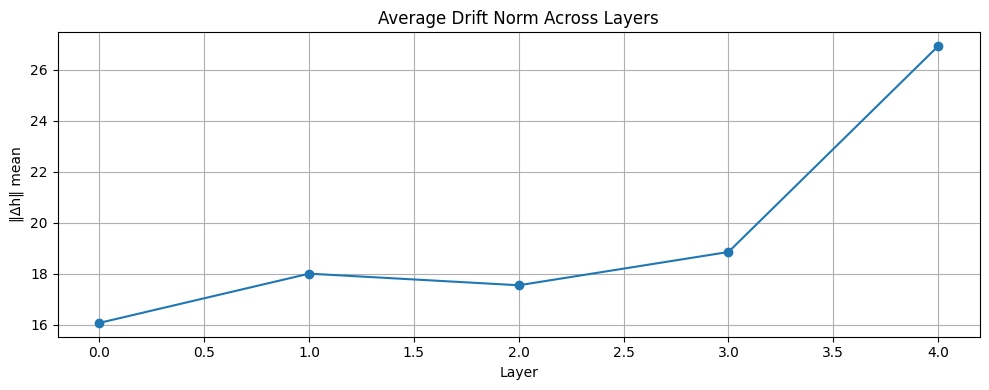

Jacobian rank (final token, projected): 66


In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = m=norm(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [11]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, x.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


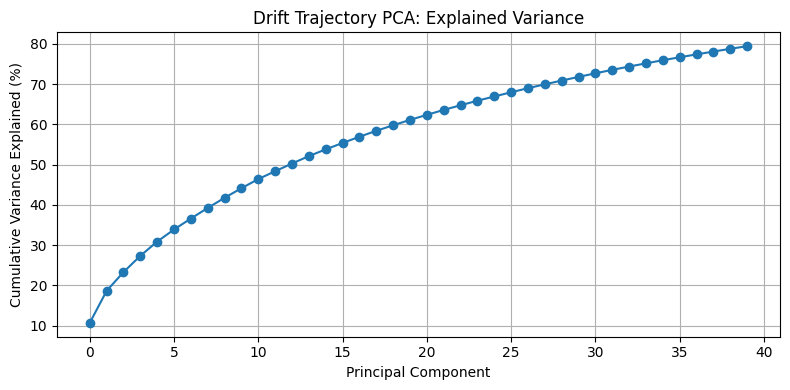

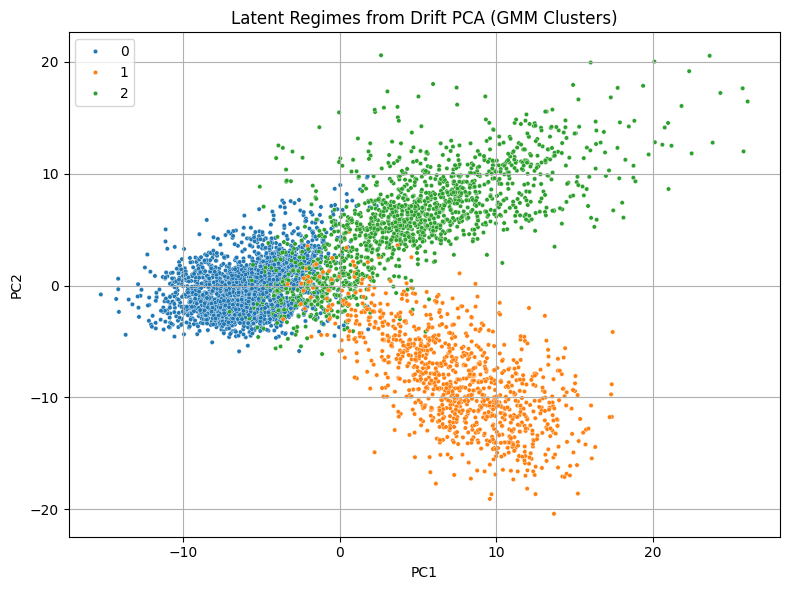

In [13]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=3)
plot_gmm_clusters(proj, labels)


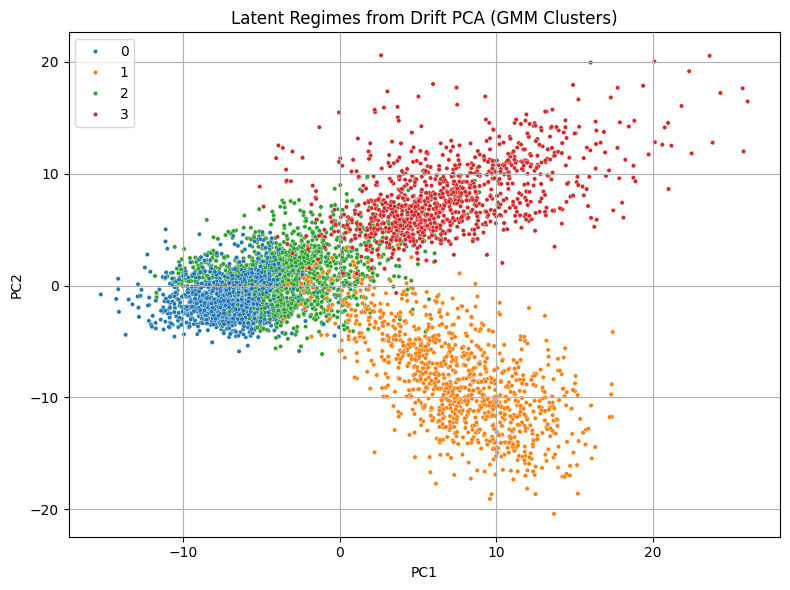

In [14]:

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)

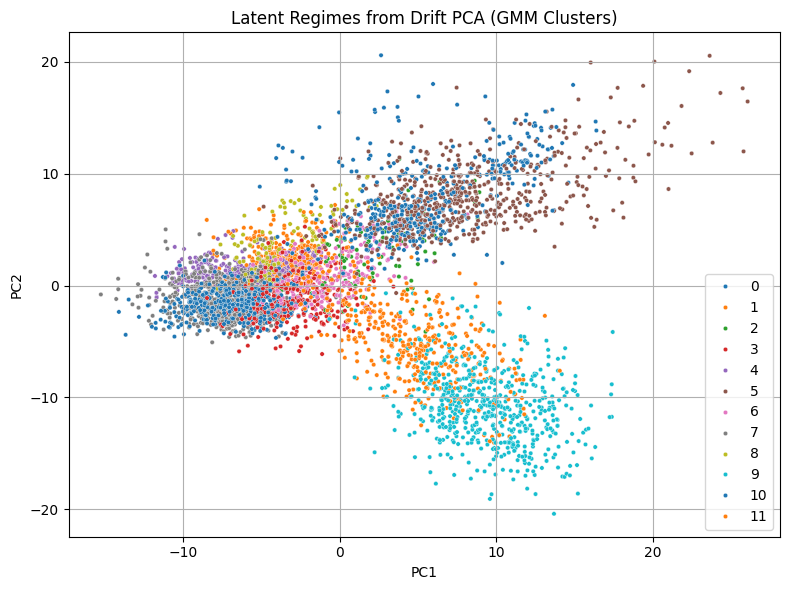

In [15]:

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=12)
plot_gmm_clusters(proj, labels)

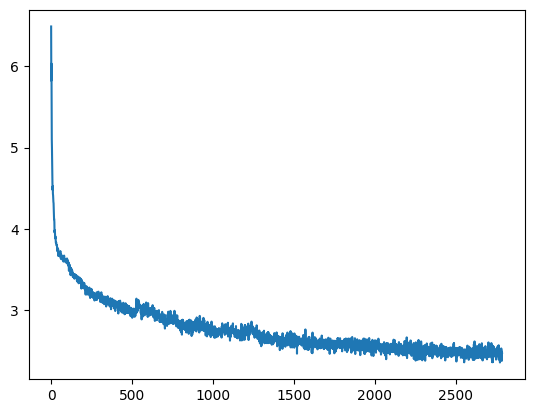

In [38]:
plt.plot(losses)

[Baseline] Val loss: 2.0621

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 2.0980 | Δ = 0.0359
Ablate Layer  1: Loss = 2.0788 | Δ = 0.0167
Ablate Layer  2: Loss = 2.0491 | Δ = -0.0131


W0112 22:46:15.070000 326 torch/_dynamo/convert_frame.py:1358] [0/8] torch._dynamo hit config.recompile_limit (8)
W0112 22:46:15.070000 326 torch/_dynamo/convert_frame.py:1358] [0/8]    function: 'forward' (/tmp/ipython-input-1761813736.py:432)
W0112 22:46:15.070000 326 torch/_dynamo/convert_frame.py:1358] [0/8]    last reason: 0/7: ___check_obj_id(self._modules['transformer']._modules['h']._modules['3'].forward.__code__, 138661070372208)  # x = block(x)  # mp/ipython-input-1761813736.py:438 in forward
W0112 22:46:15.070000 326 torch/_dynamo/convert_frame.py:1358] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0112 22:46:15.070000 326 torch/_dynamo/convert_frame.py:1358] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html


Ablate Layer  3: Loss = 2.0905 | Δ = 0.0284
Ablate Layer  4: Loss = 2.0580 | Δ = -0.0041
Ablate Layer  5: Loss = 2.0793 | Δ = 0.0171


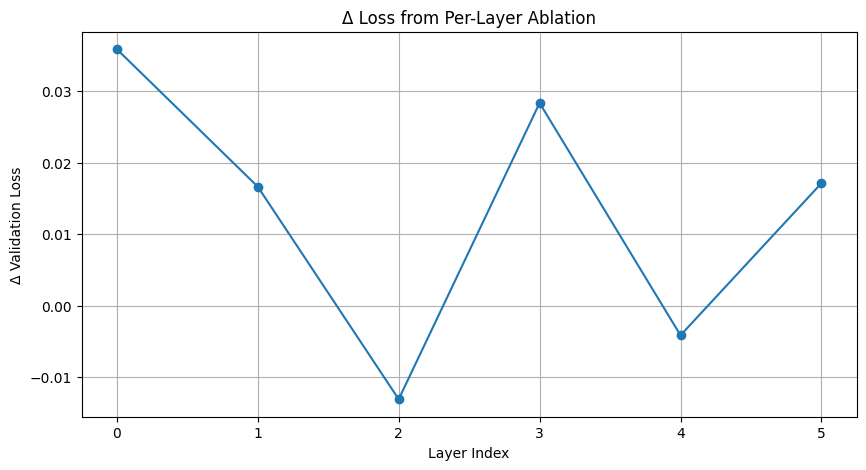

In [17]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = model.config.block_size
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


In [21]:
PATH = "model_weights.pth"

# Save only the model's learned parameters
torch.save(model.state_dict(), PATH)